In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.regularizers import l2

In [3]:
import tensorflow as tf

In [4]:
image_size = (224, 224)  # Adjust according to the input size expected by the chosen model
batch_size = 32
epochs = 100
test_split = 0.1
validation_split = 0.2

In [8]:
data_dir = '../Data/sampled_Faces/ELA_Frames'

In [10]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=validation_split,
    data_format = 'channels_first'
)

In [11]:
generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

# Split the data into training, validation, and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    generator.filepaths,
    generator.labels.astype(str),  # Convert labels to strings
    test_size=test_split,
    random_state=42
)

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images,
    train_labels,
    test_size=validation_split,
    random_state=42
)

Found 33823 images belonging to 2 classes.


In [12]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filepath': train_images, 'class': train_labels}),
    x_col='filepath',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filepath': val_images, 'class': val_labels}),
    x_col='filepath',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filepath': test_images, 'class': test_labels}),
    x_col='filepath',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)

Found 19482 validated image filenames belonging to 2 classes.
Found 1217 validated image filenames belonging to 2 classes.
Found 3383 validated image filenames belonging to 2 classes.


In [16]:
from transformers import AutoImageProcessor, TFEfficientFormerModel

ImportError: cannot import name 'logging' from 'huggingface_hub' (d:\AnaConda\envs\Cap\lib\site-packages\huggingface_hub\__init__.py)

In [11]:
# prompt: make a sequential model using tensorflow import  required librairies first

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [12]:
effmodel = TFEfficientFormerModel.from_pretrained("snap-research/efficientformer-l1-300")

Some layers from the model checkpoint at snap-research/efficientformer-l1-300 were not used when initializing TFEfficientFormerModel: ['distillation_classifier', 'classifier']
- This IS expected if you are initializing TFEfficientFormerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFEfficientFormerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFEfficientFormerModel were initialized from the model checkpoint at snap-research/efficientformer-l1-300.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFEfficientFormerModel for predictions without further training.


In [13]:
for layer in effmodel.layers:
    layer.trainable = False


In [14]:
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import GlobalAveragePooling2D

In [15]:
model = Sequential()
model.add(effmodel)
model.add(Lambda(lambda x: x['last_hidden_state']))
model.add(GRU(units=64, return_sequences=False))  # Add GRU layer here
model.add(Dense(256, activation="gelu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

In [16]:
model.compile(loss="BinaryCrossentropy",optimizer="adam",metrics=["accuracy"])

In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
history=model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Epoch 1/100
536/536 [==============================] - 197s 356ms/step - loss: 0.6577 - accuracy: 0.5998 - val_loss: 0.6160 - val_accuracy: 0.6393
Epoch 2/100
536/536 [==============================] - 133s 248ms/step - loss: 0.5713 - accuracy: 0.6946 - val_loss: 0.5576 - val_accuracy: 0.6972
Epoch 3/100
536/536 [==============================] - 130s 242ms/step - loss: 0.5137 - accuracy: 0.7406 - val_loss: 0.5320 - val_accuracy: 0.7252
Epoch 4/100
536/536 [==============================] - 111s 208ms/step - loss: 0.4633 - accuracy: 0.7733 - val_loss: 0.4845 - val_accuracy: 0.7505
Epoch 5/100
536/536 [==============================] - 114s 212ms/step - loss: 0.4284 - accuracy: 0.7953 - val_loss: 0.4634 - val_accuracy: 0.7776
Epoch 6/100
536/536 [==============================] - 114s 212ms/step - loss: 0.4027 - accuracy: 0.8110 - val_loss: 0.4621 - val_accuracy: 0.7776
Epoch 7/100
536/536 [==============================] - 112s 208ms/step - loss: 0.3742 - accuracy: 0.8279 - val_loss: 0

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_efficient_former_model (  TFBaseModelOutput(last_h  11426249 
 TFEfficientFormerModel)     idden_state=(None, None,            
                              448),                              
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 lambda (Lambda)             (None, None, 448)         0         
                                                                 
 gru (GRU)                   (None, 64)                98688     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout_15 (Dropout)        (None, 256)               0

In [20]:
def plot(history, name):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend(['train', 'val'], loc = "lower right")
    plt.title(name + " Training and Validation Accuracy Results")
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend(['train', 'val'], loc = "lower right")
    plt.title(name + " Training and Validation Loss Results")
    plt.show()

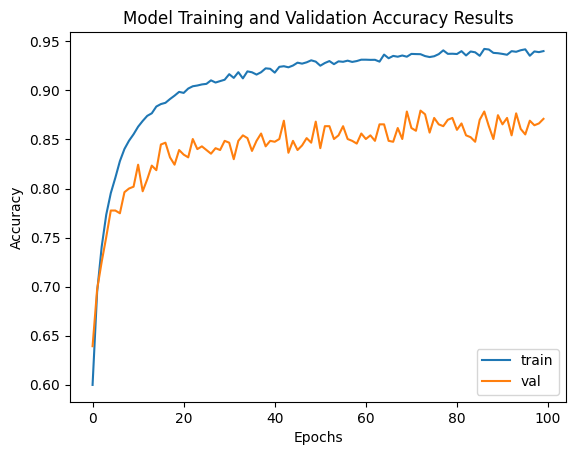

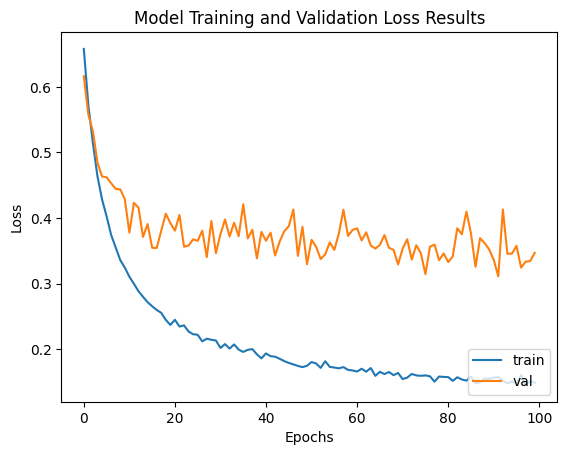

In [21]:
plot(history, "Model")

In [25]:
model.save("first.h5")

In [22]:
model1 = Sequential()
model1.add(effmodel)
model1.add(Lambda(lambda x: x['last_hidden_state']))
model1.add(GRU(units=64, return_sequences=False))  # Add GRU layer here
model1.add(Dense(32, activation="relu"))
model1.add(Dropout(0.2))
model1.add(Dense(2, activation='sigmoid'))

In [23]:
model1.compile(loss="BinaryCrossentropy", optimizer='adam', metrics=['accuracy'])


In [24]:
history1=model1.fit(train_generator, epochs=100, validation_data=val_generator)

Epoch 1/100
536/536 [==============================] - 23043s 216ms/step - loss: 0.6721 - accuracy: 0.5781 - val_loss: 0.6397 - val_accuracy: 0.6318
Epoch 2/100
234/536 [============>.................] - ETA: 56s - loss: 0.6223 - accuracy: 0.6549

KeyboardInterrupt: 

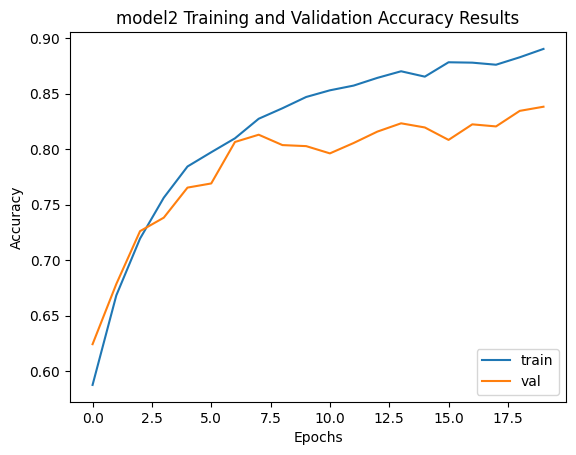

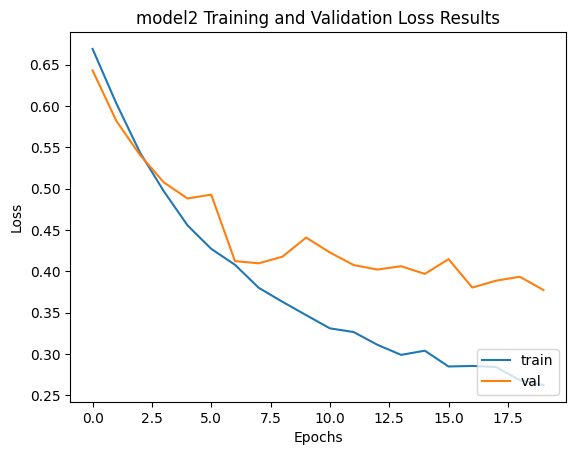

In [ ]:
plot(history1, name="model2")

In [30]:
model2 = Sequential()
model2.add(effmodel)
model2.add(Lambda(lambda x: x['last_hidden_state']))
model2.add(GRU(units=64, return_sequences=False))  # Add GRU layer here
model2.add(Dense(256, activation="gelu"))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model2.add(Dense(2, activation='sigmoid'))

In [32]:
model2.compile(loss="BinaryCrossentropy", optimizer='adam', metrics=['accuracy'])

In [33]:
history2=model2.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
536/536 [==============================] - 107s 191ms/step - loss: 0.7573 - accuracy: 0.6013 - val_loss: 0.6244 - val_accuracy: 0.6645
Epoch 2/10
536/536 [==============================] - 103s 191ms/step - loss: 0.5935 - accuracy: 0.6817 - val_loss: 0.5593 - val_accuracy: 0.6972
Epoch 3/10
536/536 [==============================] - 102s 191ms/step - loss: 0.5301 - accuracy: 0.7362 - val_loss: 0.5281 - val_accuracy: 0.7346
Epoch 4/10
536/536 [==============================] - 101s 188ms/step - loss: 0.4771 - accuracy: 0.7706 - val_loss: 0.4849 - val_accuracy: 0.7561
Epoch 5/10
536/536 [==============================] - 105s 196ms/step - loss: 0.4394 - accuracy: 0.7938 - val_loss: 0.4935 - val_accuracy: 0.7617
Epoch 6/10
536/536 [==============================] - 117s 217ms/step - loss: 0.4048 - accuracy: 0.8136 - val_loss: 0.4628 - val_accuracy: 0.7841
Epoch 7/10
536/536 [==============================] - 101s 188ms/step - loss: 0.3882 - accuracy: 0.8230 - val_loss: 0.4702 -

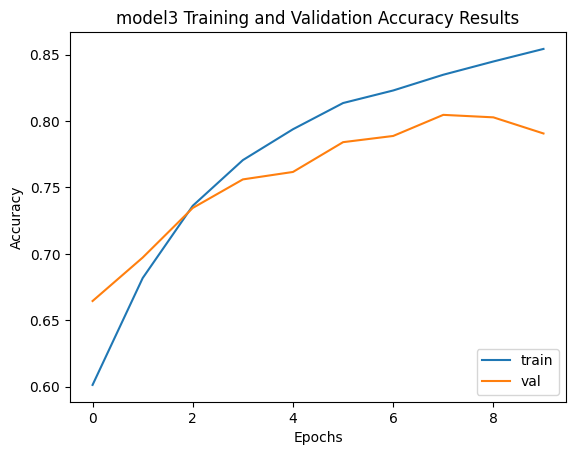

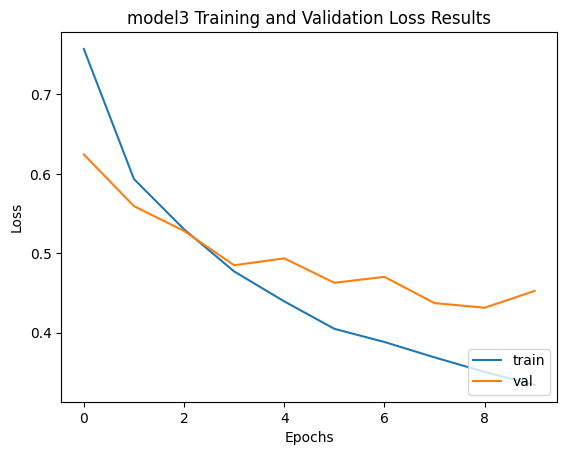

In [34]:
plot(history2, name="model3")

In [ ]:
model2.save("third.h5")

In [ ]:
model3 = Sequential()
model3.add(effmodel)
model3.add(Lambda(lambda x: x['last_hidden_state']))
model3.add(GRU(units=64, return_sequences=False))  # Add GRU layer here
model3.add(Dense(32, activation="relu"))
model3.add(Dropout(0.2))
model3.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model3.add(Dropout(0.2)
model3.add(Dense(2, activation='sigmoid'))

In [ ]:
model3.compile(loss="BinaryCrossentropy", optimizer='adam', metrics=['accuracy'])


In [ ]:
history3=model3.fit(train_generator, epochs=100, validation_data=val_generator)

In [ ]:
plot(history3, name="model3")